In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

In [2]:
# Data Extraction
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-30,-0.002078,-0.000401,0.000355,920.382019,0.285540,0.000964,0.003887,-0.046710,51.132956,1.003820,...,882.626665,0,-0.007057,0.057605,-0.002272,0.004646,0.991261,0.002001,0.004457,1.006902
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,0.005657,60.627504,1.185684,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003820,-0.002272,0.004646,0.991261
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,0.025966,63.472551,1.046927,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.185684,0.000964,0.003887,1.003820


In [3]:
# Specify Target again
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [4]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)

In [5]:
# Feature Selection only the ones that we daw on previous model are valuable
df_tts = df.copy()
df_tts = df_tts[["Returns", "Range", "RSI", "RSI_Ret", "Returns_T1", "RSI_Ret_T1", "TARGET"]]

In [6]:
# Split into X and Y Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [7]:
# Perform Train Test Split (Timeseries based method)
# not with train test split because it suffle the data and for timeseries data we dont want any suffling
# so we perform the train test split manually
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1445, 6)
Shape of y_train:  (1445,)
Shape of X_test:  (620, 6)
Shape of y_test:  (620,)
Size Matches:  True


In [8]:
# Start Building the model again
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [9]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [10]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [11]:
# Hyperparams: Recommended Params >> ne: 200, lr: 0.05 md: 1 gm: 0.1
#ne = 150
#lr = 0.05
#md = 2
#gm = 0.1

In [12]:
# another set to try: ne: 150, lr: 0.01 md: 3 gm: 6
ne = 150
lr = 0.01
md = 2
gm = 6

In [13]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [14]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(X_train, y_train, eval_metric=eval_metric_list, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=6, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [15]:
# Make the Predictions

In [16]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.68927217 0.3107278 ]
 [0.681689   0.318311  ]
 [0.6599971  0.34000286]]


In [17]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 1 0 0 0 0 0 1 0 0]
Preds Probabilities Training Data: 
 [[0.6251966  0.37480345]
 [0.45448202 0.545518  ]
 [0.67757905 0.32242092]]


In [18]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [19]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [20]:
# EVALUATION

In [21]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

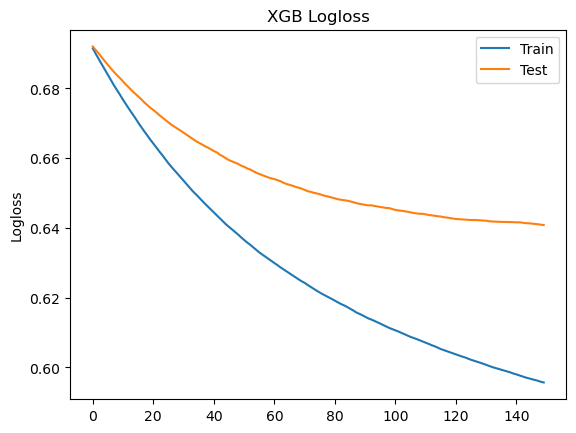

In [22]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

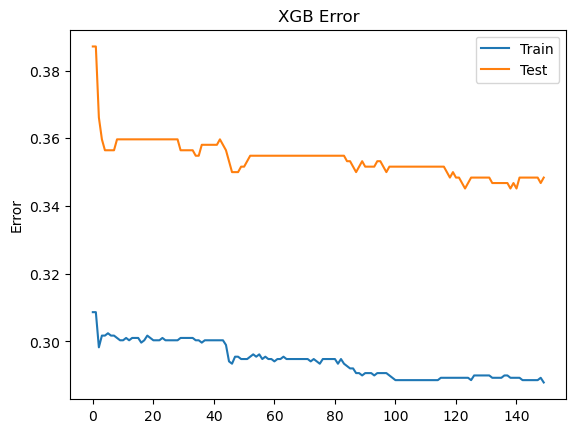

In [23]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

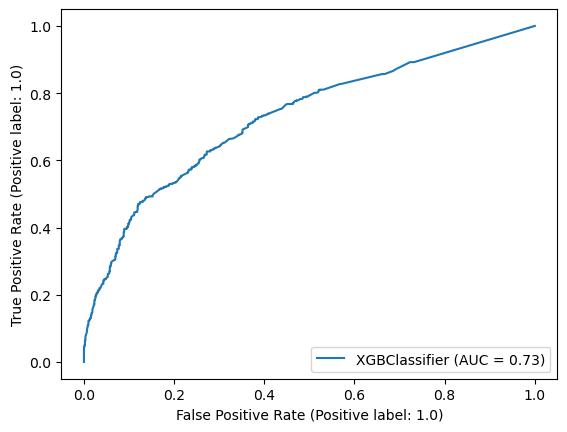

In [24]:
# Plot Training ROC Curve
plot_roc_curve(classifier, X_train, y_train)

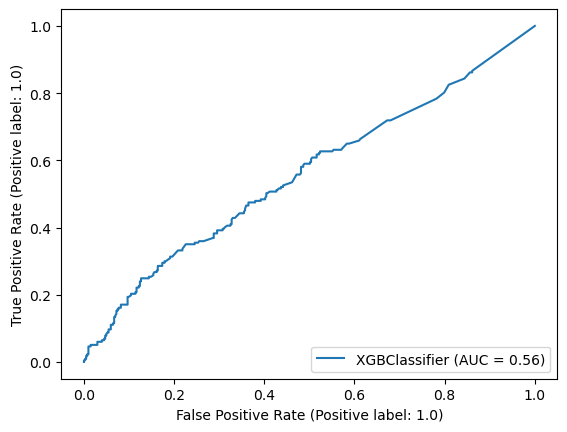

In [25]:
# Plot Test ROC Curve
plot_roc_curve(classifier, X_test, y_test)

In [26]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [27]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

In [28]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.68
Std Dev K-Fold 0.04
Precision Score 0 0.711
Precision Score 1 0.718
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.63
Std Dev K-Fold 0.29
Precision Score 0 0.666
Precision Score 1 0.509



In [29]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80       907
         1.0       0.72      0.37      0.49       538

    accuracy                           0.71      1445
   macro avg       0.71      0.64      0.65      1445
weighted avg       0.71      0.71      0.68      1445



In [30]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.67      0.93      0.78       403
         1.0       0.51      0.13      0.21       217

    accuracy                           0.65       620
   macro avg       0.59      0.53      0.49       620
weighted avg       0.61      0.65      0.58       620



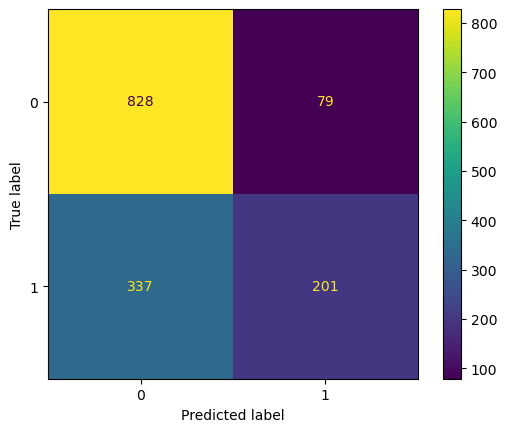

In [31]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

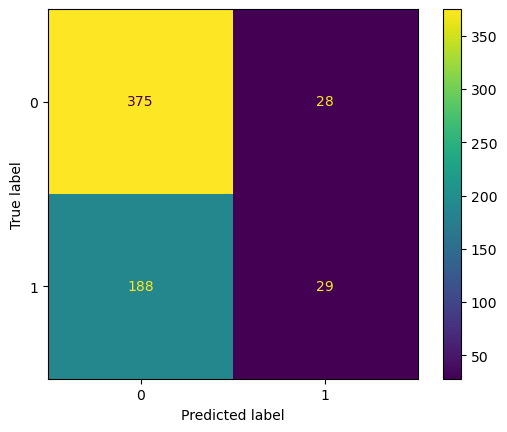

In [32]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

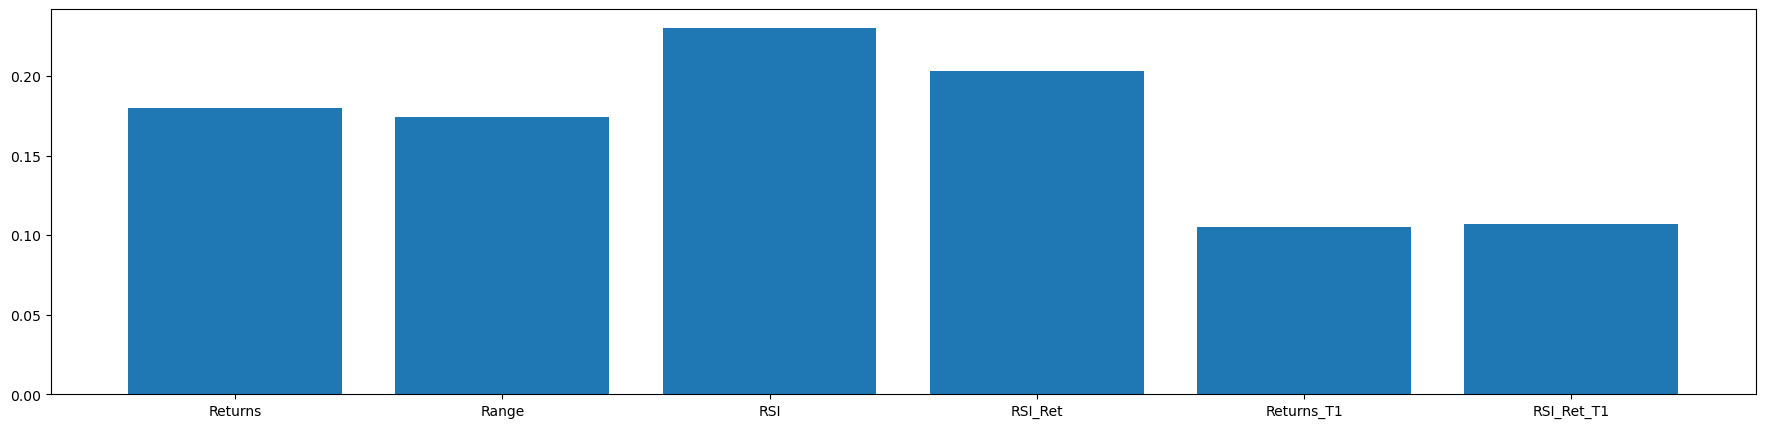

In [33]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [34]:
# To graphically see the tree
# rcParams["figure.figsize"] = 80, 50
# plot_tree(classifier)